# Observing Marcus Inverted Region

## Overview

In this notebook we will simulate the charge transfer between two molecules using the Marcus model

$$
    \hat H = -V(a^\dagger_0 a_1 + a^\dagger_1 a_0) + \Delta G a^\dagger_1 a_1 + \omega \sum_{i=0, 1} b^\dagger_i b_i + g \omega \sum_{i=0, 1} a^\dagger_i a_i (b^\dagger_i + b_i)
$$

with transfer integral $V=-0.1$, dimensionless coupling constant $g=1$, vibration frequency $\omega=0.5$.
We will show that, by decreasing the reaction Gibbs free energy change $\Delta G$, the reaction rate will first increase and then decrease, as predicted by the Marcus theory.

## Define the Hamiltonian and initial state

In [1]:
import numpy as np

from tencirchem import Op, BasisMultiElectron, BasisSHO, TimeEvolution, set_backend

set_backend("jax")

jax_backend

In [2]:
v = -0.1
g = 1
omega = 0.5
nbas = 8

In [3]:
def get_hamiltonian(delta_g):
    ham_terms = v * Op(r"a^\dagger a", ["e0", "e1"]) + v * Op(r"a^\dagger a", ["e1", "e0"])
    ham_terms += delta_g * Op(r"a^\dagger a", "e1")
    for i in range(2):
        ham_terms += omega * Op(r"b^\dagger b", f"v{i}")
        ham_terms += g * omega * Op(r"a^\dagger a", f"e{i}") * Op(r"b^\dagger+b", f"v{i}")
    basis = [BasisMultiElectron(["e0", "e1"], [0, 0]), BasisSHO("v0", omega, nbas), BasisSHO("v1", omega, nbas)]
    return ham_terms, basis

In [4]:
# using a relaxed initial state
def get_init_condition():
    basis = BasisSHO(0, omega, nbas)
    state = np.linalg.eigh(basis.op_mat(r"b^\dagger b") + g * basis.op_mat(r"b^\dagger+b"))[1][:, 0]
    return {"v0": state}

## Run simulation
Next, we run the simulation using the `TimeEvolution` class with the custom initial state. 
The execution may take 10-20 minutes since it's a 7-qubit system and 5 trajectories are generated.

In [5]:
n_list = []
delta_g_list = np.linspace(0, -2, 5)
for delta_g in delta_g_list:
    ham_terms, basis = get_hamiltonian(delta_g)
    init_condition = get_init_condition()
    te = TimeEvolution(ham_terms, basis, init_condition=init_condition, property_op_dict={"n": Op("a^\dagger a", "e0")})
    for i in range(40):
        te.kernel(0.2)
    n_list.append(te.property_dict["n"].real)

## Analyze and plot

In [6]:
from matplotlib import pyplot as plt
import mpl_config

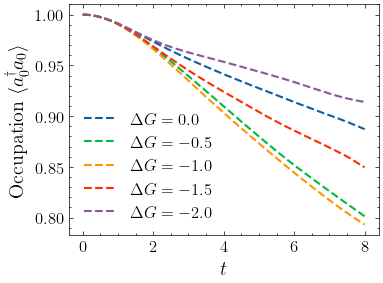

In [7]:
t = np.arange(41) * 0.2
for i, n in enumerate(n_list):
    label = r"$\Delta G =" + str(delta_g_list[i]) + "$"
    plt.plot(t, n.real[:, 0], label=label, linestyle="--")
plt.xlabel("$t$")
plt.ylabel(r"Occupation $\langle a^\dagger_0 a_0 \rangle$")
plt.legend()

The Marcus rate is

$$
k = \frac{V^2}{\hbar} \sqrt{\frac{\pi\beta}{\lambda}} \exp{\left (-\frac{\beta(\lambda + \Delta G)^2}{4\lambda} \right )}
$$
where $\lambda = 2g^2\omega$ is the reorganization energy.
Since temperature is not considered in this simulation, $\beta$ need to be fitted.

In [8]:
# fit charge transfer rate
rate = [-np.polyfit(t[10:], n[:, 0][10:], 1)[0] for n in n_list]
rate

[0.014047289363197032,
 0.02814188436474036,
 0.029197240764329252,
 0.019342655847204578,
 0.01011515881320177]

Next, compare the simulated rate with the Marcus rate and the nuclear tunneling charge transfer rate ([*Phys. Rev. B* **2009**, *79*, 115203](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.79.115203))

In [9]:
from matplotlib import pyplot as plt
import mpl_config
import numpy as np

delta_g_list = np.linspace(0, -2, 5)
rate = [0.014048168006004535, 0.028141822635725088, 0.02919731407299346, 0.019324510938040215, 0.01011515881320177]

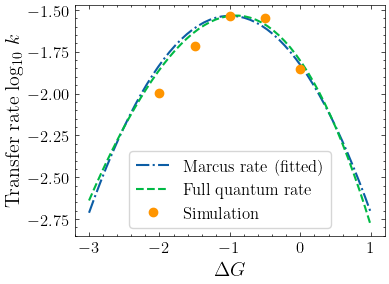

In [10]:
# marcus rate
def marcus_rate(delta_g, beta):
    lam = 2 * g**2 * omega
    return v**2 * np.sqrt(np.pi * beta / lam) * np.exp(-(beta * (lam + delta_g) ** 2) / (4 * lam))


# fit temperature
from scipy.optimize import curve_fit

beta = curve_fit(marcus_rate, delta_g_list, rate)[0][0]
from scipy.integrate import trapezoid


# nuclear tunneling rate
def nuclear_tunneling_rate(delta_g):
    s = g**2
    t = np.linspace(-6, 6, int(1e3))
    integrand = v**2 * np.exp(
        1j * delta_g * t - s * (1 - np.exp(1j * omega * t)) - s * (-1j * omega * t + omega**2 * t**2)
    )
    return trapezoid(integrand.real, t.ravel())


dense_delta_g = np.linspace(-3, 1)
plt.plot(
    dense_delta_g,
    np.log10([marcus_rate(delta_g, beta) for delta_g in dense_delta_g]),
    linestyle="-.",
    label="Marcus rate (fitted)",
)
plt.plot(
    dense_delta_g,
    np.log10([nuclear_tunneling_rate(delta_g) for delta_g in dense_delta_g]),
    linestyle="--",
    label="Full quantum rate",
)
plt.plot(delta_g_list, np.log10(rate), linestyle="", marker="o", markersize=6, label="Simulation")
plt.xlabel(r"$\Delta G$")
plt.ylabel("Transfer rate log$_{10} \ k$")
plt.legend(frameon=True)

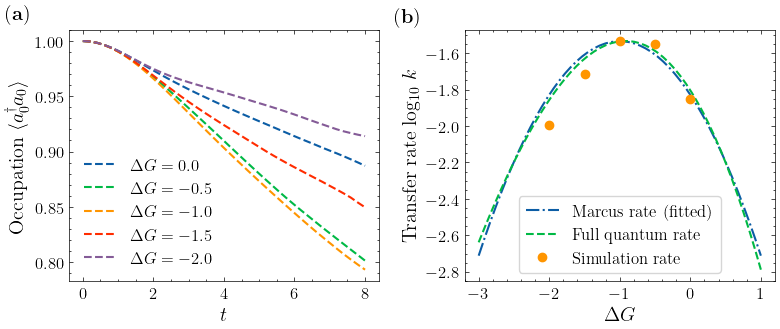

In [11]:
fig = plt.figure(figsize=(8, 3.5), tight_layout=True)
ax1, ax2 = fig.subplots(1, 2)

plt.sca(ax1)
for i, n in enumerate(n_list):
    label = r"$\Delta G =" + str(delta_g_list[i]) + "$"
    plt.plot(t, n.real[:, 0], label=label, linestyle="--")
plt.xlabel("$t$")
plt.ylabel(r"Occupation $\langle a^\dagger_0 a_0 \rangle$")
plt.text(-2.2, 1.02, r"$(\bf{a})$", fontsize="x-large")
plt.legend()

plt.sca(ax2)
plt.plot(
    dense_delta_g,
    np.log10([marcus_rate(delta_g, beta) for delta_g in dense_delta_g]),
    linestyle="-.",
    label="Marcus rate (fitted)",
)
plt.plot(
    dense_delta_g,
    np.log10([nuclear_tunneling_rate(delta_g) for delta_g in dense_delta_g]),
    linestyle="--",
    label="Full quantum rate",
)
plt.plot(delta_g_list, np.log10(rate), linestyle="", marker="o", markersize=6, label="Simulation rate")
plt.xlabel(r"$\Delta G$")
plt.ylabel("Transfer rate log$_{10} \ k$")
plt.text(-4.2, -1.43, r"$(\bf{b})$", fontsize="x-large")
plt.legend(frameon=True)
plt.savefig("marcus.pdf")